# Advanced Machine Learning - programming assignment 2

**Please fill in:**
* Ernö Groeneweg (4279662)
* Otto Mättas (6324363)
* Vincent de Wit (6970877)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set.

In [1]:
import numpy as np
import itertools
import graphviz # conda install python-graphviz

The graphviz can draw graphs to different file formats, or show them directly in the notebook. We will use numpy arrays to represent graphs. The following function converts such an array to a graph in graphviz format. 

In [2]:
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

In [3]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

ExecutableNotFound: failed to execute ['circo', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

Here is a function that performs the PC algorithm. Add the missing code for phase 2, and implement phases 3 and 4.

In [4]:
def PC_algorithm(n, independence_tester):
    # PHASE I: Initialization
    # The matrix G represents a graph as follows:
    # - For all x, G[x,x] == False
    # - G[x,y] == False and G[y,x] == False: no edge between x and y
    # - G[x,y] == True  and G[y,x] == True:  undirected edge x --- y
    # - G[x,y] == True  and G[y,x] == False: directed edge x --> y
    G = np.logical_not(np.eye(n, dtype=bool))

    # PHASE II: Skeleton search
    # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
    sepset = dict()
    for k in range(n-1):
        for x in range(n):
            for y in range(n):
                if not G[x,y]:
                    continue
                # Try all subsets S of Adj(x) \ {y} with |S|=k,
                # until an independence is found.
                # Hint: use itertools.combinations
                
                # Your code here
                # G[x,y] is true here , this means that y is adjacent to x
                # for all S subset of adjacent nodes to x not including y, with size of S: |S|=k
                l = [i for i in range(n) if (i != y and i != x)] # range n excluding y and x since adj to x
                Set = itertools.combinations(l,k) # all combinations of length k
                
                for S in Set:
                    indep = independence_tester.test_independence(x, y, S)
                    if indep:
                        print("independence found: {0} and {1} given {2}".format(x,y,S))
                        G[x,y] = G[y,x] = False
                        S_mask = np.zeros(n, dtype=bool)
                        np.put(S_mask, S, True)
                        sepset[frozenset([x,y])] = S_mask
                        break
        # Do we need to continue with smaller k? ....
        max_S_size = np.sum(G, axis=0) - 1
        if np.all(max_S_size < k + 1):
            break

    # PHASE III: Orient v-structures
    # Something to watch out for:
    # If the data are not faithful to any graph, the algorithm may end up trying
    # to orient a single edge in two different ways. You can choose either
    # orientation if this happens.

    # Your code here
    # for two not adjacent nodes connected to a third node
    # check if this third node is in the sepset of the two
    # not connected nodes. When the third node is not in
    # the sepset, the two first nodes collide in the third.

    for x in range(n-1):
        for y in range(x,n):
            # if x and y not adjacent
            if G[x,y] == G[y,x] == False and x != y:
                for z in range(n):
                    
                    # when z is adjacent to x and to y
                    if G[x,z] == False and G[z,x] == False:
                        continue
                    if G[y,z] == False and G[z,y] == False:
                        continue
                        
                    # unordered when atleast one edge is undirected
                    if not (G[x,z]==G[z,x]==True or G[y,z]==G[z,y]==True):
                        continue
                        
                    # if z not in sepset({x,y}):
                    if not sepset[frozenset([x,y])][z]:
                        # orient edges
                        G[z,x] = G[z,y] = False
                        
        # Not implemented "Something to watch out for" I do not understand when this exactly would happen...

    # PHASE IV: Orientation rules

    # Your code here
    # no extra v-structures, no cycles
    
    # undirected edges
    for x in range(n-1):
        for y in range(x,n):
            # if x and y adjacent and undirected
            if not(G[x,y] == G[y,x] == True and x != y):
                continue
                
            # x and y adjacent and undirected
            print(x,y)

    '''
    rule 1: When a node has an incoming edge and an undirected edge
                    then the undirected edge becomes a directed outgoing edge.
    rule 2: When two nodes are connected by an undirected edge and 
                have a directed chain connecting them via a third node
                    then the undirected edge becomes a directed edge with the same direction as the chain.
    rule 3: When two nodes are connected by an undirected edge and
                one node has two incoming edges that 'relate' to the 'other' node
                    then the undirected edge becomes a directed edge directed at the node with incoming edges.
    '''
    

    return G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an /oracle/ instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, PC should be able to recover the Markov equivalence class of the true graph.

In [5]:
def is_d_connected_dfs(mB, pos, w, S, vis):
    # Made modifications to deal with CPDAGs as input
    #print("At ", pos)
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v])
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

class IndependenceOracle:
    def __init__(self, true_G):
        self.G = true_G
        self.n = true_G.shape[0]
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        #S_mask[S] = True
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph G1 we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

independence found: 0 and 2 given ()
independence found: 0 and 3 given ()
independence found: 1 and 3 given (2,)
2 3
CORRECT


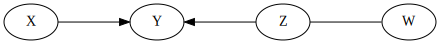

In [6]:
oracle = IndependenceOracle(G1)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G1) else "INCORRECT")
graph_to_graphviz(G, node_names)

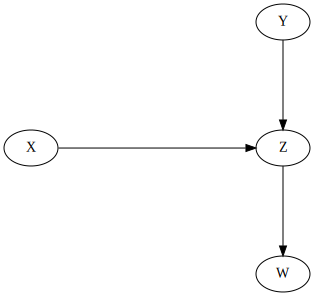

In [7]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (2,)
independence found: 1 and 3 given (2,)
2 3
INCORRECT


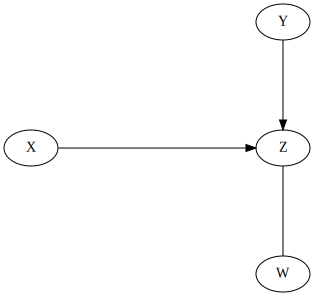

In [8]:
oracle = IndependenceOracle(G2)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G2) else "INCORRECT")
graph_to_graphviz(G, node_names)

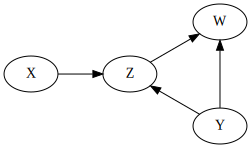

In [9]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: 0 and 1 given ()
independence found: 0 and 3 given (1, 2)
1 3
2 3
INCORRECT


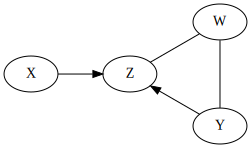

In [10]:
oracle = IndependenceOracle(G3)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G3) else "INCORRECT")
graph_to_graphviz(G, node_names)

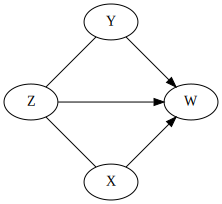

In [11]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: 0 and 1 given (2,)
0 2
1 2
2 3
INCORRECT


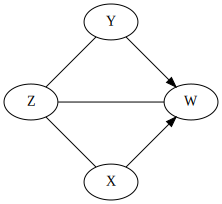

In [12]:
oracle = IndependenceOracle(G4)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G4) else "INCORRECT")
graph_to_graphviz(G, node_names)

## Running PC on data
This part of the assignment will appear soon.